In [1]:
import torch
import DDPM_CNN

/home/jimmy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = DDPM_CNN.CompleteModel3()

station = '馬祖'
kind = '三合一'
TEST = 'TEST_'
model.load_state_dict(torch.load(TEST + 'TORCH3_' + station + '_' + kind + '.pth', map_location=torch.device('cpu')))
model.eval()

CompleteModel3(
  (main_branch): MainBranch(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (mlp): Mlp

In [3]:
import sys
import os

current_dir = current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from image_process import SaturationMap, DarkChannel

/home/jimmy/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
from torchvision import transforms
import numpy as np
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img)
    return img_tensor

def preprocess_auxiliary(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    dark = DarkChannel(img_np)
    saturation = SaturationMap(img_np)
    aux_input_tensor = torch.cat([transforms.ToTensor()(dark), transforms.ToTensor()(saturation)], dim=0)
    return aux_input_tensor

In [5]:
# 單張圖片測試

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

df_test = pd.read_csv(parent_dir + '/' + station + '/' + station + '_三合一.csv')
test_image = "075-20190302063442.jpg"

row = df_test[df_test['filename'] == test_image]
image_path = parent_dir + "/" + station + "/" + station + "resize三合一/" + test_image

image_tensor = preprocess_image(image_path)
aux_input_tensor = preprocess_auxiliary(image_path)

if not row.empty:
    pm_value = row['PM2.5'].iloc[0]
    rh_value = row['RH'].iloc[0]
    print(f"The PM2.5 value for {test_image} is: {pm_value}")
    print(f"The RH value for {test_image} is: {rh_value}")
else:
    print(f"No data found for {test_image}")

The PM2.5 value for 075-20190302063442.jpg is: 20.0
The RH value for 075-20190302063442.jpg is: 96.0


In [10]:
image_tensor = image_tensor.float()
aux_input_tensor = aux_input_tensor.float()
rh_tensor = torch.tensor([rh_value], dtype=torch.float32)

In [11]:
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0), aux_input_tensor.unsqueeze(0), rh_tensor)
    pm25_concentration = output.item()

print(f"Estimated PM2.5 concentration: {pm25_concentration:.4f}")

Estimated PM2.5 concentration: 15.5457


In [8]:
# 畫回歸圖

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class DataGenerator(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_name = row['filename']
        image_path = os.path.join(self.image_folder, image_name)
        RH_value = row['RH']
        

        if not os.path.exists(image_path):
            print(f"Warning: {image_path} does not exist. Skipping this file.")
            return torch.zeros(3, 224, 224), torch.zeros(2, 224, 224), torch.zeros(1), 0.0
            
        main_input = preprocess_image(image_path)
        aux_input = preprocess_auxiliary(image_path)
        RH_tensor = torch.tensor([RH_value], dtype=torch.float32)

        label = row['PM2.5']

        # Apply image transformations
        if self.transform:
            main_input = self.transform(main_input)
            aux_input = self.transform(aux_input)

        return (main_input, aux_input, RH_tensor), label

In [ ]:
# 2018-9~2019-7

In [9]:
image_folder = parent_dir + '/' + station + '/' + station + 'resize三合一'

train_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_train.csv')
val_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_valid.csv')
test_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_test.csv')

In [10]:
train_dataset = DataGenerator(train_df, image_folder=image_folder, transform=None)
val_dataset = DataGenerator(val_df, image_folder=image_folder, transform=None)
test_dataset = DataGenerator(test_df, image_folder=image_folder, transform=None)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
actuals = []
predictions = []

# 無梯度推理
with torch.no_grad():
    for inputs, labels in val_loader:
        main_inputs, aux_inputs, RH = inputs
        main_inputs = main_inputs.to(device).float()
        aux_inputs = aux_inputs.to(device).float()
        RH = RH.to(device).float()
        labels = labels.to(device).float()

        outputs = model(main_inputs, aux_inputs, RH)
        outputs = outputs.squeeze()

        outputs = outputs.cpu().numpy()
        if outputs.ndim == 0:
            outputs = np.expand_dims(outputs, 0)

        # 結果
        actuals.extend(labels.tolist())
        predictions.extend(outputs.tolist())


actuals = np.array(actuals)
predictions = np.array(predictions)

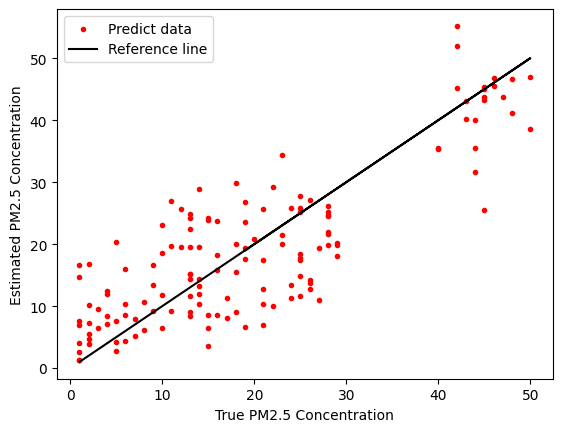

In [12]:
import matplotlib.pyplot as plt

plt.scatter(actuals, predictions, color='red', marker='.', label='Predict data')
plt.plot(actuals, actuals, color='black', label='Reference line')
plt.xlabel('True PM2.5 Concentration')
plt.ylabel('Estimated PM2.5 Concentration')
plt.legend()
plt.show()

In [ ]:
# 2018-1~2018-8

In [19]:
import pandas as pd

df_test = pd.read_csv(parent_dir + '/' + station + '/' + station + '_三合一_前.csv')
test_image = "047-20180104162229.jpg"

row = df_test[df_test['filename'] == test_image]
image_path = parent_dir + "/" + station + "/" + station + "resize三合一_前/" + test_image

image_tensor = preprocess_image(image_path)
aux_input_tensor = preprocess_auxiliary(image_path)

if not row.empty:
    pm_value = row['PM2.5'].iloc[0]
    rh_value = row['RH'].iloc[0]
    print(f"The PM2.5 value for {test_image} is: {pm_value}")
    print(f"The RH value for {test_image} is: {rh_value}")
else:
    print(f"No data found for {test_image}")

The PM2.5 value for 047-20180104162229.jpg is: 64.0
The RH value for 047-20180104162229.jpg is: 75.4


In [20]:
image_tensor = image_tensor.to(device).float()
aux_input_tensor = aux_input_tensor.to(device).float()
rh_tensor = torch.tensor([rh_value], dtype=torch.float32, device=device)

In [21]:
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0), aux_input_tensor.unsqueeze(0), rh_tensor)
    pm25_concentration = output.item()

print(f"Estimated PM2.5 concentration: {pm25_concentration:.4f}")

Estimated PM2.5 concentration: 13.8843
